In [6]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [10]:
import pandas as pd

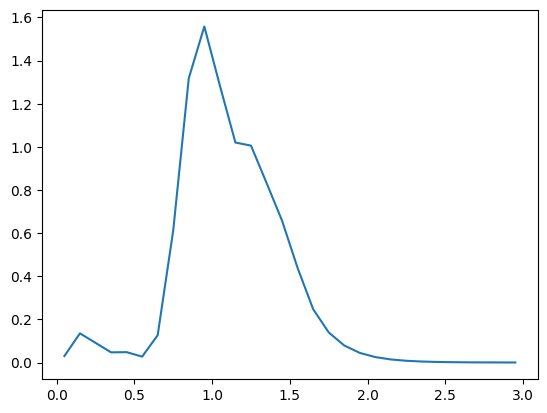

In [13]:
# redshift information
dndz = pd.read_csv("data/gal/elg_fuji_pz_single_tomo.csv")
pz = dndz['pz']
zrange = dndz['Redshift_mid']

plt.plot(zrange,pz)

In [68]:
from astropy.cosmology import Planck18 as planck
from astropy import constants as const
planck_const_h = const.h
c = const.c 
boltzmann_kb = const.k_B
OmegaM = planck.Om0
H0 = planck.H0
Hz = planck.H(zrange.values)
chi = planck.comoving_distance(zrange)
z = zrange.values

In [69]:
z

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95])

In [77]:
for i in range(len(z)):
    zspecific_indx = i
    tst = chi[zspecific_indx]/chi[z >= z[zspecific_indx]]
    print(len(tst))

30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [64]:
map_tomo = np.load("data/gal/dr9_elgs.npy")
ngal_tot = map_tomo.sum()
dndz_number = pz.values * ngal_tot

In [78]:
from scipy.integrate import simpson

In [115]:
def W_gal(b_gal, pz = pz.values, z = zrange.values, 
          mag_bias_alpha = 2.225):
    """
    Returns redshift kernel of galaxy field
    """
    
    gal_bias_term = b_gal * pz 
    
    mag_bias_prefact = 3 * OmegaM/(2 * c)
    mag_bias_prefact = (mag_bias_prefact * H0**2/Hz * (1 +z) * chi).decompose() # to reduce to the same unit
    
    integrated_values = np.zeros_like(z)
    for i in range(len(z)): # loop over to get integrand values 
      zspecific_indx = i
      
      # only consider bins above the specific index 
      flag = (z >= z[zspecific_indx])
      ratio = chi[zspecific_indx]/chi[flag]
      
      # assuming constant alpha over z 
      integrand_term = (1 - ratio) * (mag_bias_alpha - 1) * pz[flag]
      integrated_values[i] = simpson(y = integrand_term, x = z[flag])
  
    mag_bias_term = mag_bias_prefact * integrated_values
    return gal_bias_term + mag_bias_term

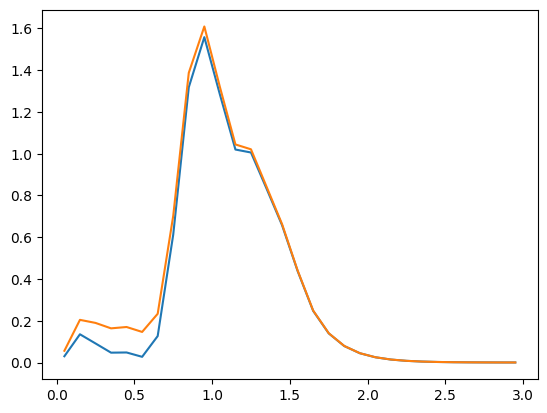

In [117]:
plt.plot(zrange, pz.values)
plt.plot(zrange, W_gal(1))#/W_gal(1).max())

## Produce CIB Redshift Kernel

In [3]:
def plancks_function_ratio(nu, nu0, T):
    """Returns the ratio of Planck's black body spectral radiance between
    frequencies nu and nu0 for a blackbody of temperature T.
    
    nu : frequency in units of s^-1
    nu0 : frequency in units of s^-1
    T : Temperature in units of Kelvin
    """
    
    h_over_kB = 4.799e-11 #units of seconds * Kelvin
    h_over_kBT = h_over_kB/T #units of seconds
    
    first_term = 1/(np.exp(h_over_kBT * nu) - 1) 
    second_term = np.exp(h_over_kBT * nu0) - 1
    
    return first_term * second_term

In [4]:
plancks_function_ratio(1e11, 2.5e11, 25)

2.910437733647662

In [14]:
def get_CIB_SED(nu, z, nu0 = 2.5e11, beta = 1.75, 
            gamma = 1.7, T0 = 22.4, alpha = 0.36):
    """Returns the CIB SED as a function of frequency nu and redshift z.
    
    Parameters
    ----------
        nu0 : reference frequency in units of Hz
        beta : gray-body emissitvity factor
        gamma : high-frequency power-law exponent
        T0 : dust temperature today
        alpha : index controlling the temperature redshift evolution
        
    Returns
    -------
        theta: SED model array"""
        
    nu_ratio = nu/nu0
    
    # dust temperature model
    Td = T0 * (1 + z)**alpha
    if (nu >= nu0):
        CIB_SED = nu_ratio**(-1 * gamma) * np.ones_like(z)
        print("ok")
    else:
        nu_ratio = nu_ratio**beta 
        blackbody_ratio_factor = plancks_function_ratio(nu, nu0, Td)
        CIB_SED = nu_ratio * blackbody_ratio_factor
        
    return CIB_SED
        

In [15]:
tst = get_CIB_SED(1e11, np.arange(0, 3, 0.1))

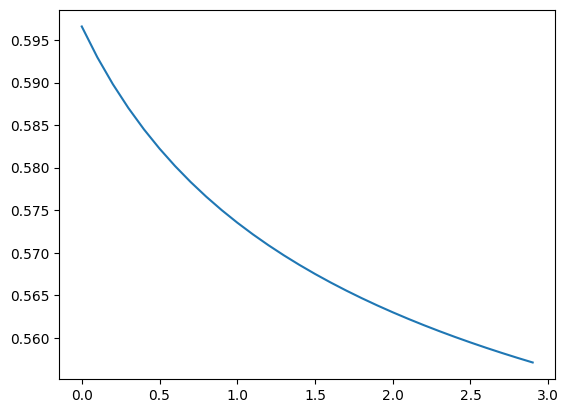

In [17]:
plt.plot(np.arange(0, 3, 0.1), tst)

# Test Abhi's code to produce $C_{\rm CIB-g} (\ell)$ 

### Read in Abhi's theory code

In [ ]:
cibs = {}
cibs[353]

In [2]:
masks = {}

freqs = [353, 545, 857]

for f in freqs:
    masks[f] = hp.read_map(f"{str(f)}mask.fits")

In [4]:
theory = np.genfromtxt("PlanckCIB353GHzxDESI_ELGgalaxy_rl1.0.txt", 
              names = ['ell', '1h', '2h', 'shot', 'total'])

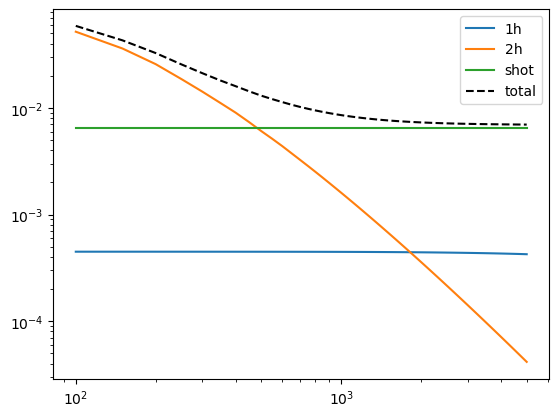

In [8]:
plt.plot(theory['ell'], theory['1h'], label = '1h')
plt.plot(theory['ell'], theory['2h'], label = '2h')
plt.plot(theory['ell'], theory['shot'], label = 'shot')
plt.plot(theory['ell'], theory['total'], label = 'total', ls = '--', c = 'k')
plt.yscale("log")
plt.xscale("log")
plt.legend(loc = 'best')